In [1]:
from env import host, username, password, get_db_url
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import mitosheet
import lux

Pandas backend loaded 1.3.4
Numpy backend loaded 1.20.3
Pyspark backend NOT loaded
Python backend loaded


- Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

- Construct a model to __predict assessed home value for single family properties__ using regression techniques.

- We want to be able to __predict the property tax assessed values ('taxvaluedollarcnt') of Single Family Properties that had a transaction during 2017__.

- We have a model already, but we are hoping your insights can help us improve it. I need recommendations on a way to make a better model. Maybe you will create a new feature out of existing ones that works better, try a non-linear regression algorithm, or try to create a different model for each county. Whatever you find that works (or doesn't work) will be useful. Given you have just joined our team, we are excited to see your outside perspective.

- One last thing, Zach lost the email that told us where these properties were located. Ugh, Zach :-/. __Because property taxes are assessed at the county level, we would like to know what states and counties these are located in.__

- Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?


# Planning
One thing I find interesting out the gate, if not a little suspicious, is that taxvaluedollarcount is always the sum of structuretaxvaluedollarcnt and landtaxvaluedollarcnt; but sometimes, the land and structure amount are the same.  



In [2]:
def acquire_zillow_data(use_cache=True):
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached CSV')
        return pd.read_csv('zillow.csv')
    print('Acquiring data from SQL database')
    df = pd.read_sql('''
                        SELECT bedroomcnt, 
                               bathroomcnt, 
                               calculatedfinishedsquarefeet, 
                               taxvaluedollarcnt, 
                               yearbuilt, 
                               fips          
                        FROM properties_2017
                            JOIN propertylandusetype USING (propertylandusetypeid)
                            JOIN predictions_2017 USING(parcelid)
                        WHERE propertylandusedesc IN ('Single Family Residential', 
                                                        'Inferred Single Family Residential')
                            AND transactiondate LIKE '2017%%';
                    
                     '''
                    , get_db_url('zillow'))
    df.to_csv('zillow.csv', index=False)
    
    
    return df

In [18]:
df = acquire_zillow_data()


Using cached CSV


In [57]:
df.shape

(52441, 7)

In [19]:
#just in case there are blanks
df = df.replace(r'^\s*$', np.NaN, regex=True)

# drop all nulls, for an affect of .00586 on data
df.dropna(axis=0, how='any', inplace=True)

In [59]:
df.shape

(52319, 7)

In [20]:
 # modify two columns
df['fips'] = df.fips.apply(lambda fips: '0' + str(int(fips)))
df['yearbuilt'] = df['yearbuilt'].astype(int)
df.yearbuilt = df.yearbuilt.astype(object)

In [6]:
def describe_data(df):
    print('The first three rows are: ')
    print('----------------------------------------------------------')
    print(df.head(3))
    print('----------------------------------------------------------')
    print("The data frame's shape is: ")
    print('-------------------------')
    print(f' Rows: {df.shape[0]} \n Columns: {df.shape[1]}')
    print('-------------------------')   
    print('The data types and column names are: ')
    print(sorted(df))
    print(df.info())
    print('----------------------------------------------------------')   
    print('The summary statistics are as follows: ')
    print('----------------------------------------------------------')
    print(df.describe())
    print('----------------------------------------------------------')      
    print(f'The number of NA\'s is:')
    print('-------------------------')
    print(df.isna().sum())
    print('-------------------------')
    print ('\nMissing values :  ', df.isnull().sum().values.sum())
    print('----------------------------------------------------------')  
    print('Unique Values for the Columns:')
    print('-------------------------')
    limit = 10
    for col in df.columns:
        if df[col].nunique() < limit:
            print(f'Column: {col} \n')
            print(f'Unique Values: {df[col].unique()} \n')
            print(f'Absolute frequencies: \n {df[col].value_counts()} \n')
            print(f'Relative frequencies: \n {df[col].value_counts(normalize=True)} \n')
        else: 
            print(f'Column: {col} \n')
            print(f'Range of Values: [{df[col].min()} - {df[col].max()}] \n')
        print('-----------------------')
    print('-------Done-zo-------------')

In [7]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet  taxvaluedollarcnt  \
0         4.0          3.5                        3100.0          1023282.0   
1         2.0          1.0                        1465.0           464000.0   
2         3.0          2.0                        1243.0           564778.0   

  yearbuilt   fips  roomcnt  
0      1998  06059      0.0  
1      1967  06111      5.0  
2      1962  06059      6.0  
----------------------------------------------------------
The data frame's shape is: 
-------------------------
 Rows: 52319 
 Columns: 7
-------------------------
The data types and column names are: 
['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'roomcnt', 'taxvaluedollarcnt', 'yearbuilt']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52440
Data columns (total 7 columns):
 #   Column                        Non-Null Count  

In [45]:
report = ProfileReport(df)

In [46]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
df.dtypes

beds         float64
baths        float64
area         float64
tax_value    float64
yearbuilt     object
fips          object
roomcnt      float64
age           object
dtype: object

In [21]:
 #create a new column named 'age', which is the difference of yearbuilt and 2017
df['age'] = 2017-df['yearbuilt']

df = df.rename(columns={
                    'calculatedfinishedsquarefeet': 'area',
                    'bathroomcnt': 'baths',
                    'bedroomcnt': 'beds',
                    'taxvaluedollarcnt':'tax_value'}
          )

In [22]:
def remove_outliers(df, k, col_list):
    for col in col_list:
        
        q1, q3 = df[col].quantile([.25, .75])
        
        iqr = q3 - q1
        
        upper_bound = q3 + k * iqr
        lower_bound = q1 - k * iqr
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

df = remove_outliers(df, 1.5, ['beds', 'baths', 'area', 'tax_value', 'age'])

# Note, when moving this to a report later, modify the kwargs so that train, validate and test
# are fed into this function and subsequently returned. 

#train = train[(train[col] > lower_bound) & (train[col] < upper_bound)]
#validate = validate[(validate[col] > lower_bound) & (validate[col] < upper_bound)]
#test = test[(test[col] > lower_bound) & (test[col] < upper_bound)]

In [10]:
report = ProfileReport(df)

In [11]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Univariate Analysis - Visualize data distribution using histrograms for numeric variables and bar carts for categorical variables.
Why do we need to do this? UA facilitates id'ing if a dataset contains outliers and whether the data needs to be transformed or feature engineered. 

Why do we need correlation analysis?
- identify collinearity between independent variables — linear regression assumes no collinearity among independent features, therefore it is essential to drop some features if collinearity exists. In this example, none of the independent variables are highly correlated with another, hence no need of dropping any.
- identify independent variables that are strongly correlated with the target — they are the strong predictors. Once again, we can see that “smoker” is correlated with expenses.

In [8]:
# populate the list of numeric attributes and categorical attributes

num_list = []
cat_list = []

for column in df: 
    if pd.api.types.is_numeric_dtype(df[column]):
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df[column]):
        cat_list.append(column)
        
print(num_list)
print(cat_list)

['beds', 'baths', 'area', 'tax_value', 'roomcnt']
['yearbuilt', 'fips', 'age']


In [9]:
missing_count = df.isnull().sum() # the count of missing values
value_count = df.isnull().count() # the count of all values
missing_percentage = round(missing_count / value_count * 100, 2) # percentage of missing values
missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage}) # create df
print(missing_df)

           count  percentage
beds           0         0.0
baths          0         0.0
area           0         0.0
tax_value      0         0.0
yearbuilt      0         0.0
fips           0         0.0
roomcnt        0         0.0
age            0         0.0


In [10]:
# If I wanted to visualize this data frame
barchart = missing_df.plot.bar(y='percentage')

for index, percentage in enumerate(missing_percentage):
    barchart.text(index, percentage, str(percentage) + '%')

- Categorical Variables → Bar chart
   -  The easiest yet most intuitive way to visualize the property of a categorical variable is to use a bar chart to plot the frequency of each categorical value.
- Numerical Variables → histogram
    - To graph out the numeric variable distribution, we can use histogram which is very similar to bar chart. It splits continuous numbers into equal size bins and plot the frequency of records falling between the interval.

In [42]:
# can't get this to run
#for column in df:
#    plt.figure(column)
#    plt.title(column)
#    if pd.api.types.is_numeric_dtype(df[column]):
#        df[column].plot(kind = 'hist')
#    elif pd.api.types.is_string_dtype(df[column]):
#        # only TOP 10 value count in each categorical data
#        df[column].plot(kind = 'bar')

The features you use influence more than everything else the result. No algorithm alone, to my knowledge, can supplement the information gain given by correct feature engineering.
— Luca Massaron

"The most simple solution to the missing values is to drop the rows or the entire column. There is not an optimum threshold for dropping but you can use 70% as an example value and try to drop the rows and columns which have missing values higher than the threshold. For example:


In [43]:
threshold = 0.7

#Dropping columns with missing value rate higher than the threshold
df = df[df.columns[df.isnull().mean() < threshold]]

# Dropping rows with missing value rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]

        

In [48]:
df.describe(include='all')

beds         baths          area     tax_value  yearbuilt  \
count   45238.000000  45238.000000  45238.000000  4.523800e+04    45238.0   
unique           NaN           NaN           NaN           NaN      107.0   
top              NaN           NaN           NaN           NaN     1955.0   
freq             NaN           NaN           NaN           NaN     1821.0   
mean        3.214886      2.110858   1707.257306  3.738880e+05        NaN   
std         0.788707      0.727000    613.148093  2.447062e+05        NaN   
min         2.000000      1.000000    152.000000  1.000000e+03        NaN   
25%         3.000000      2.000000   1243.000000  1.750410e+05        NaN   
50%         3.000000      2.000000   1577.000000  3.376940e+05        NaN   
75%         4.000000      2.500000   2071.000000  5.230000e+05        NaN   
max         5.000000      4.000000   3566.000000  1.124001e+06        NaN   

         fips       roomcnt      age  
count   45238  45238.000000  45238.0  
unique      3           NaN    107.0  
top     06037           NaN     62.0  
freq    29337           NaN   1821.0  
mean      NaN      1.955126      NaN  
std       NaN      3.125917      NaN  
min       NaN      0.000000      NaN  
25%       NaN      0.000000      NaN  
50%       NaN      0.000000      NaN  
75%       NaN      5.000000      NaN  
max       NaN     12.000000      NaN

Numerical Imputation
- Imputation is a more preferable option rather than dropping because it preserves the data size. However, there is an important selection of what you impute to the missing values. I suggest beginning with considering a possible default value of missing values in the column. For example, if you have a column that only has 1 and NA, then it is likely that the NA rows correspond to 0. For another example, if you have a column that shows the “customer visit count in last month”, the missing values might be replaced with 0 as long as you think it is a sensible solution.
- Another reason for the missing values is joining tables with different sizes and in this case, imputing 0 might be reasonable as well.
- Except for the case of having a default value for missing values, I think the best imputation way is to use the medians of the columns. As the averages of the columns are sensitive to the outlier values, while medians are more solid in this respect.

In [49]:
# filling all missing values with 0
# data = data.fillna(0)

# filling missing values with medians of the columns
# data = data.fillna(data.median())

"The main motivation of binning is to make the model more robust and prevent overfitting, however, it has a cost to the performance. Every time you bin something, you sacrifice information and make your data more regularized. (Please see regularization in machine learning)      

The trade-off between performance and overfitting is the key point of the binning process. In my opinion, for numerical columns, except for some obvious overfitting cases, binning might be redundant for some kind of algorithms, due to its effect on model performance.
        
However, for categorical columns, the labels with low frequencies probably affect the robustness of statistical models negatively. Thus, assigning a general category to these less frequent values helps to keep the robustness of the model. For example, if your data size is 100,000 rows, it might be a good option to unite the labels with a count less than 100 to a new category like “Other”."

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

4.Log Transform
Logarithm transformation (or log transform) is one of the most commonly used mathematical transformations in feature engineering. What are the benefits of log transform:
- It helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
- In most of the cases the magnitude order of the data changes within the range of the data. For instance, the difference between ages 15 and 20 is not equal to the ages 65 and 70. In terms of years, yes, they are identical, but for all other aspects, 5 years of difference in young ages mean a higher magnitude difference. This type of data comes from a multiplicative process and log transform normalizes the magnitude differences like that.
- It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.
     -   A critical note: The data you apply log transform must have only positive values, otherwise you receive an error. Also, you can add 1 to your data before transform it. Thus, you ensure the output of the transformation to be positive.

In [ ]:
##Log Transform Example
#data = pd.DataFrame({'value':[2,45, -23, 85, 28, 2, 35, -12]})
#data['log+1'] = (data['value']+1).transform(np.log)
##Negative Values Handling
##Note that the values are different
#data['log'] = (data['value']-data['value'].min()+1) .transform(np.log)


In [52]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

Count Column Type
0       beds     float64
1      baths     float64
2       area     float64
3  tax_value     float64
4  yearbuilt      object
5       fips      object
6    roomcnt     float64
7        age      object

In [53]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Column Type  Count
0     float64      5
1      object      3

In [12]:
#show(df)

In [11]:
#fig = plt.scatter(data_frame=df, x='tax_value', y='baths', hue='fips')
#fig.update()
#show(fig)

In [12]:
#mitosheet.sheet(df)

In [8]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
#df_filtered = df.head(1000)

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.scatter(df, x='tax_value', y='baths', color='fips')
fig.update_layout(
    title='tax_value, baths scatter plot',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")

In [11]:
import plotly.express as px

# Filter the dataframe so that it does not crash the browser
#df_filtered = df.head(1000)

# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.ecdf(df, x='tax_value', y='beds', color='fips')
fig.update_layout(
    title='tax_value, beds ecdf',
    xaxis=dict(
        rangeslider=dict(
            visible=True,
            thickness=.05
        )
    )
)
fig.show(renderer="iframe")

In [9]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [14]:
vis = df.exported[0]
vis

LuxWidget(current_vis={'config': {'view': {'continuousWidth': 400, 'continuousHeight': 300}, 'axis': {'labelCo…

In [15]:
print(vis.to_code("matplotlib"))

import matplotlib.pyplot as plt
plt.rcParams.update(
            {
                "axes.titlesize": 20,
                "axes.titleweight": "bold",
                "axes.labelweight": "bold",
                "axes.labelsize": 16,
                "legend.fontsize": 14,
                "legend.title_fontsize": 15,
                "xtick.labelsize": 13,
                "ytick.labelsize": 13,
            }
        )
import numpy as np
from math import nan
df = pd.DataFrame({'age': {0: 1.0, 1: 11.6, 2: 22.2, 3: 32.8, 4: 43.4, 5: 54.0, 6: 64.6, 7: 75.2, 8: 85.8, 9: 96.39999999999999}, 'Number of Records': {0: 994.0, 1: 3118.0, 2: 4149.0, 3: 4684.0, 4: 6435.0, 5: 12106.0, 6: 7565.0, 7: 2270.0, 8: 3067.0, 9: 850.0}})
fig, ax = plt.subplots()
bars = df['age']
measurements = df['Number of Records']
ax.bar(bars, measurements, width=8.833333333333334)
ax.set_xlabel('age (binned)')
ax.set_ylabel('Number of Records')

fig


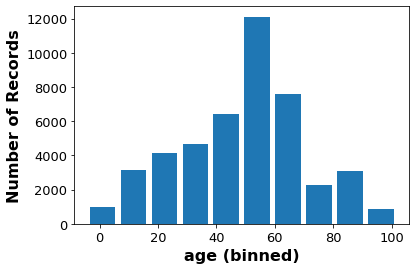

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update(
            {
                "axes.titlesize": 20,
                "axes.titleweight": "bold",
                "axes.labelweight": "bold",
                "axes.labelsize": 16,
                "legend.fontsize": 14,
                "legend.title_fontsize": 15,
                "xtick.labelsize": 13,
                "ytick.labelsize": 13,
            }
        )
import numpy as np
from math import nan
df = pd.DataFrame({'age': {0: 1.0, 1: 11.6, 2: 22.2, 3: 32.8, 4: 43.4, 5: 54.0, 6: 64.6, 7: 75.2, 8: 85.8, 9: 96.39999999999999}, 'Number of Records': {0: 994.0, 1: 3118.0, 2: 4149.0, 3: 4684.0, 4: 6435.0, 5: 12106.0, 6: 7565.0, 7: 2270.0, 8: 3067.0, 9: 850.0}})
fig, ax = plt.subplots()
bars = df['age']
measurements = df['Number of Records']
ax.bar(bars, measurements, width=8.833333333333334)
ax.set_xlabel('age (binned)')
ax.set_ylabel('Number of Records')

fig

In [17]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Properties that have 0 beds but at least 1 bath could be studios so those will not be droppe

In [ ]:
# removing rows with 0 bed and 0 bath
df = df[(df['num_baths'] > 0) & (df['num_beds'] > 0)]

In [ ]:
# confirm changes have been applied
df[['num_beds', 'num_baths']][(df.num_baths == 0.0) & (df.num_beds == 0.0)].count()